In [316]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu
import array_utils as au


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [317]:

trial_file = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv'
trial_df = pd.read_csv(trial_file)

In [318]:
session_file = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv'
session_df = pd.read_csv(session_file)


In [319]:
session_df.columns.to_list()

['subject_id',
 'session_date',
 'nwb_suffix',
 'session',
 'rig',
 'user_name',
 'curriculum_name',
 'curriculum_version',
 'current_stage_actual',
 'task',
 'notes',
 'experiment_description',
 'session_start_time',
 'session_end_time',
 'session_run_time_in_min',
 'water_in_session_foraging',
 'water_in_session_manual',
 'water_in_session_total',
 'water_after_session',
 'water_day_total',
 'base_weight',
 'target_weight',
 'target_weight_ratio',
 'weight_after',
 'laser_1_calibration_power',
 'laser_2_calibration_power',
 'laser_1_target_areas',
 'laser_2_target_areas',
 'commit_ID',
 'repo_url',
 'current_branch',
 'weight_after_ratio',
 'p_reward_sum_mean',
 'p_reward_sum_std',
 'p_reward_sum_median',
 'p_reward_contrast_mean',
 'p_reware_contrast_median',
 'effective_block_length_mean',
 'effective_block_length_std',
 'effective_block_length_median',
 'effective_block_length_min',
 'effective_block_length_max',
 'duration_gocue_stop_mean',
 'duration_gocue_stop_std',
 'duration_

In [320]:
# Filtering

session_df_filt = session_df.loc[:, ['subject_id', 'session_date', 
                                     'session', 'curriculum_name', 'curriculum_version', 
                                     'current_stage_actual', 'task', 'p_reward_sum_mean', 
                                     'effective_block_length_mean','autowater_collected', 'autowater_ignored',
                                     'ignore_rate', 'reward_rate', 'finished_rate', 'double_dipping_rate_finished_trials',
                                     'double_dipping_rate_finished_reward_trials',
                                     'double_dipping_rate_finished_noreward_trials',
                                     'lick_consistency_mean_finished_trials',
                                     'lick_consistency_mean_finished_reward_trials',
                                     'lick_consistency_mean_finished_noreward_trials',
                                     'foraging_performance', 'foraging_eff', 'early_lick_rate', 
                                     'invalid_lick_ratio', 'double_dipping_rate_finished_trials', 
                                     'lick_consistency_mean_finished_trials']]

session_df_filt.columns.to_list()


['subject_id',
 'session_date',
 'session',
 'curriculum_name',
 'curriculum_version',
 'current_stage_actual',
 'task',
 'p_reward_sum_mean',
 'effective_block_length_mean',
 'autowater_collected',
 'autowater_ignored',
 'ignore_rate',
 'reward_rate',
 'finished_rate',
 'double_dipping_rate_finished_trials',
 'double_dipping_rate_finished_reward_trials',
 'double_dipping_rate_finished_noreward_trials',
 'lick_consistency_mean_finished_trials',
 'lick_consistency_mean_finished_reward_trials',
 'lick_consistency_mean_finished_noreward_trials',
 'foraging_performance',
 'foraging_eff',
 'early_lick_rate',
 'invalid_lick_ratio',
 'double_dipping_rate_finished_trials',
 'lick_consistency_mean_finished_trials']

In [321]:
# Feature notes

# finished rate -- upwards increase at stage level, plateu at session 20

# ignore rate -- downwards decrease at stage level, plateu at session 20

# reward rate -- V shape (STAGE_3) at stage level, sig. decrease until session 10 then slow decrease

# median reaction time -- normal (but only until STAGE_FINAL) decrease at stage level, ONLY until session ~7

# mean reaction time -- normal (but only until STAGE_FINAL) decrease at stage level, ONLY until session ~7

# early lick rate -- upwards V shape (STAGE_3) at stage level, plateu at session 20

# invalid lick ratio -- slight increase at stage level (but only until STAGE_FINAL), ONLY until session ~7

# double dipping rate (finished trials) -- large decrease at until STAGE_2, then flat,  plateu at session 20

# double dipping rate rewarded (finished trials) -- decrease at stage level,  plateu at session 10

# double dipping rate non-rewarded (finished trials) -- decrease at stage level but only until STAGE_2,  plateu at session 10

# lick consistency mean (finished trials) -- increase at stage level, plateu at session 20

# lick consistency mean (finished reward trials) -- increase at stage level, plateu at session 10

# lick consistency mean (finished non-rewarded trials) -- increase until STAGE 3, then slight decrease, plateu at session 10



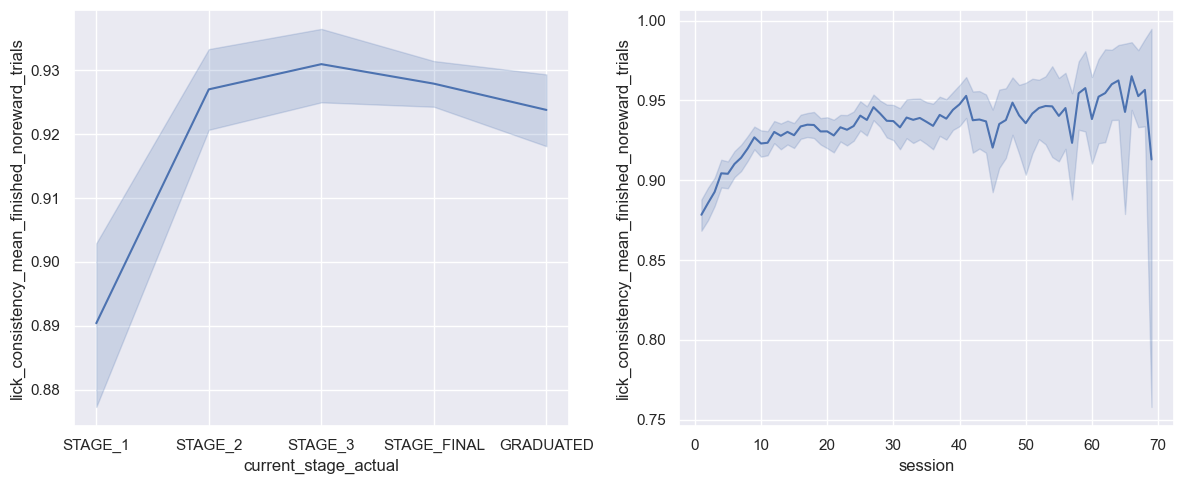

In [399]:

# Define stage order
stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']
session_df['current_stage_actual'] = pd.Categorical(session_df['current_stage_actual'], categories=stage_order)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

metric = 'lick_consistency_mean_finished_noreward_trials'

# Plot by stage
sns.lineplot(data=session_df, x='current_stage_actual', y=metric, ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=session_df, x='session', y= metric, 
              ax=ax2)


plt.tight_layout()

In [322]:
# Protyping metrics

test_session_df = session_df.copy()

# Prototype metric 1: 1 / (early lick rate + double dipping rate)
test_session_df['prototype_metric_1'] = np.where(
    (test_session_df['early_lick_rate'] + test_session_df['double_dipping_rate_finished_trials']) != 0,
    (1/ (test_session_df['early_lick_rate'] + test_session_df['double_dipping_rate_finished_trials'])),
    np.inf
)

# Prototype metric 2: finished rate / (early lick rate + double dipping rate)
test_session_df['prototype_metric_2'] = np.where(
    (test_session_df['early_lick_rate'] + test_session_df['double_dipping_rate_finished_trials'] + test_session_df['finished_rate']) != 0,
    (test_session_df['finished_rate'] / (test_session_df['early_lick_rate'] + test_session_df['double_dipping_rate_finished_trials'])),
    np.inf
)

# Prototype metric 3: finished rate / (double dipping rate + reaction time*0.0001)
test_session_df['prototype_metric_3'] = np.where(
    (test_session_df['finished_rate'] + test_session_df['double_dipping_rate_finished_trials'] + test_session_df['reaction_time_mean']) != 0,
    ((test_session_df['finished_rate'] / test_session_df['double_dipping_rate_finished_trials'] + (test_session_df['reaction_time_mean']*0.0001))),
    np.inf
)

# Prototype metric 4: finished rate / (finished rate + double dipping rate + reaction time)
test_session_df['prototype_metric_4'] = np.where(
    (test_session_df['finished_rate'] + test_session_df['double_dipping_rate_finished_trials'] + test_session_df['reaction_time_mean']) != 0,
    (test_session_df['finished_rate'] / (test_session_df['finished_rate'] + test_session_df['double_dipping_rate_finished_trials'] + test_session_df['reaction_time_mean'])),
    np.inf
)

# Prototype metric 5: finished rate * lick consistency / (1 + early_lick_rate + double_dipping_rate)
test_session_df['prototype_metric_5'] = (
    (2 * test_session_df['finished_rate'] * test_session_df['reward_rate'] * 
     test_session_df['lick_consistency_mean_finished_trials']) /
    (1 + test_session_df['early_lick_rate'] + 
     2 * test_session_df['double_dipping_rate_finished_trials'] +
     test_session_df['invalid_lick_ratio'])
)

# Preprocessing 
#test_session_df = bu.filter_by_group_size(test_session_df, group_col='subject_id', max_rows=30)
test_session_df = bu.clean_dataframe(test_session_df, threshold=0.5, verbose=True)
test_session_df = bu.add_session_column(test_session_df)

# Define stage order
stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']
test_session_df['current_stage_actual'] = pd.Categorical(test_session_df['current_stage_actual'], categories=stage_order)

Removed 0 rows with more than 50.0% NaN values

Remaining NaN counts per column:
laser_1_calibration_power         8986
laser_2_calibration_power         8985
laser_1_target_areas              8966
laser_2_target_areas              8965
results_location                  7480
                                  ... 
logistic_Hattori2019_UnrC_amp        2
logistic_Hattori2019_UnrC_tau        2
logistic_Su2022_UnrC_tau             2
logistic_Miller2021_Reward_tau       1
logistic_Miller2021_Reward_amp       1
Length: 91, dtype: int64

Original DataFrame shape: (9083, 168)
Cleaned DataFrame shape: (9083, 168)


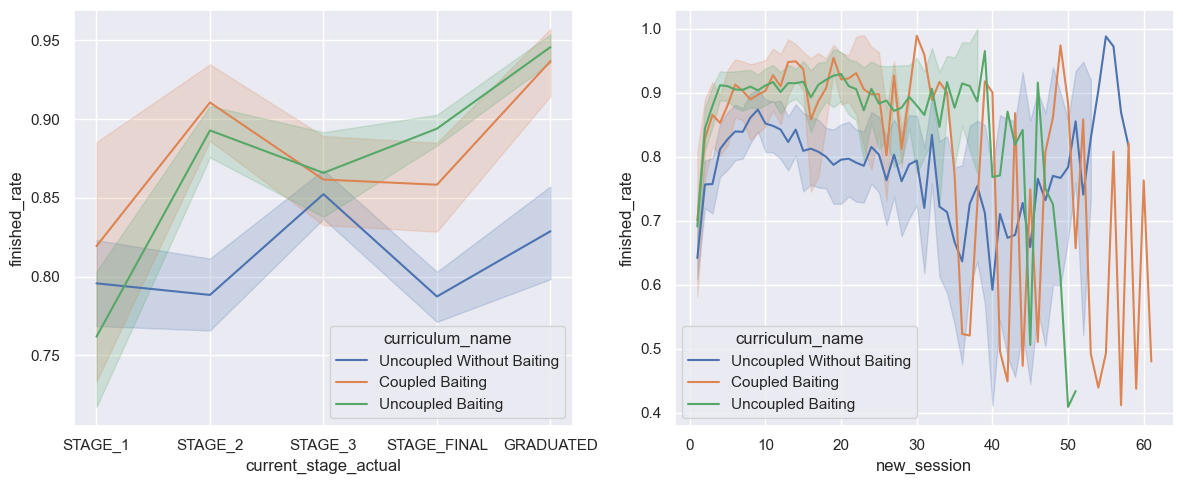

In [323]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='finished_rate', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='finished_rate', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

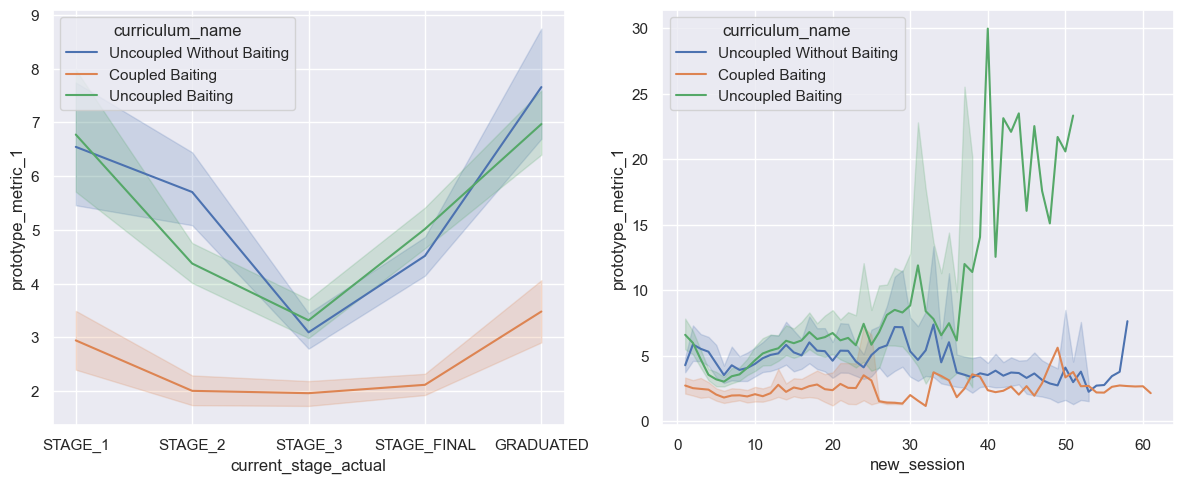

In [324]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='prototype_metric_1', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='prototype_metric_1', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

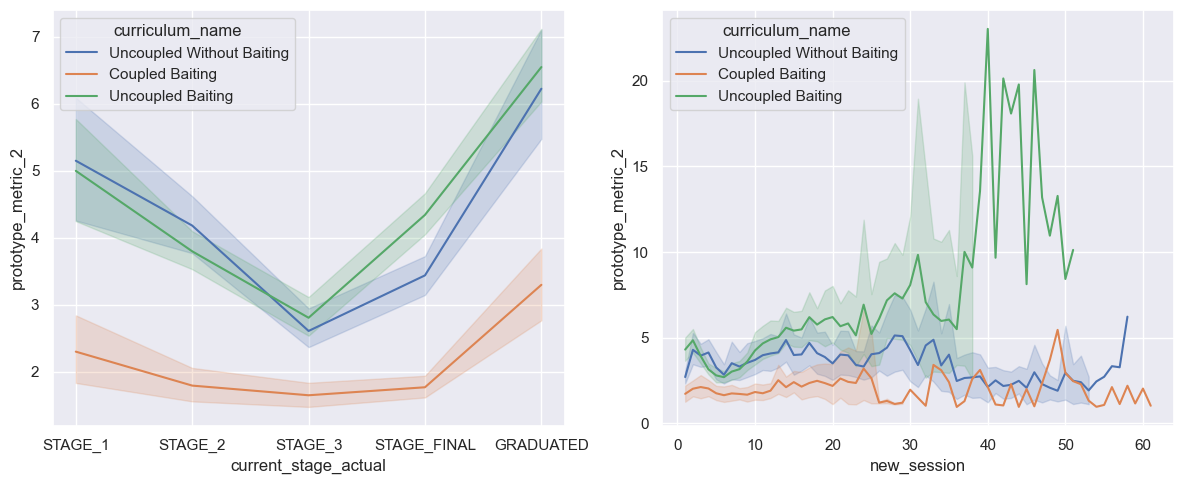

In [325]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='prototype_metric_2', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='prototype_metric_2', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

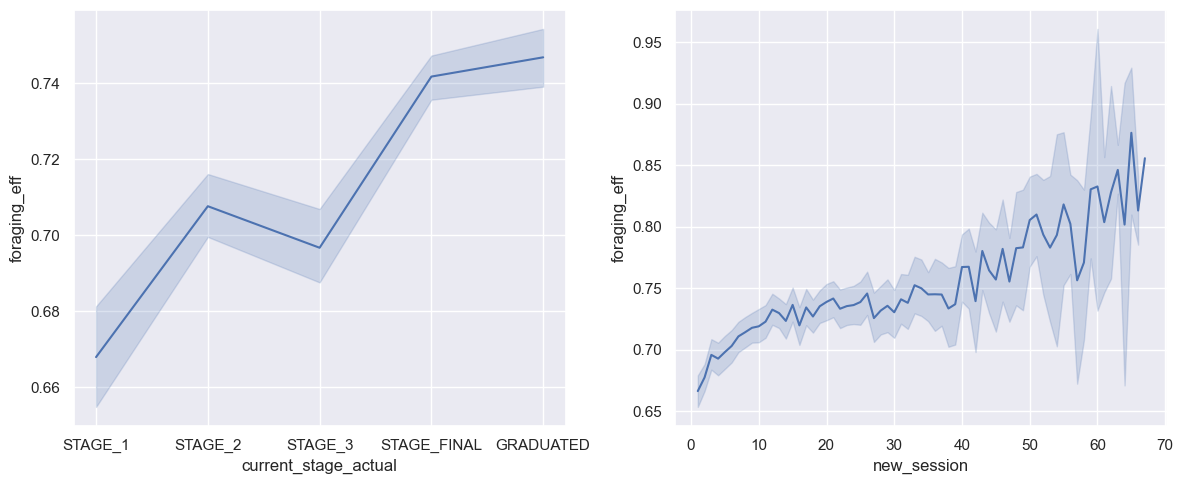

In [400]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='foraging_eff', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='foraging_eff', 
              ax=ax2)


plt.tight_layout()

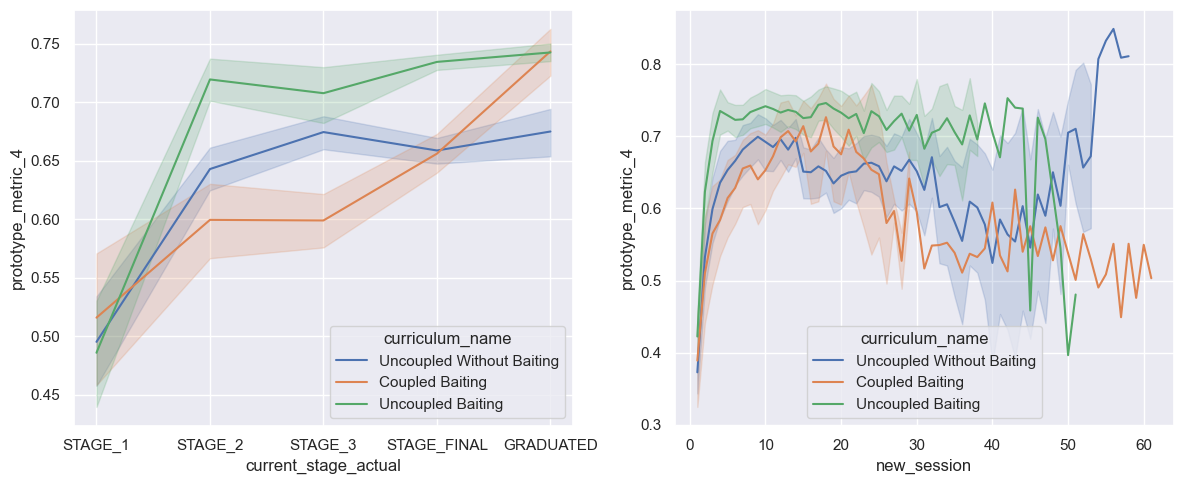

In [327]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='prototype_metric_4', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='prototype_metric_4', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

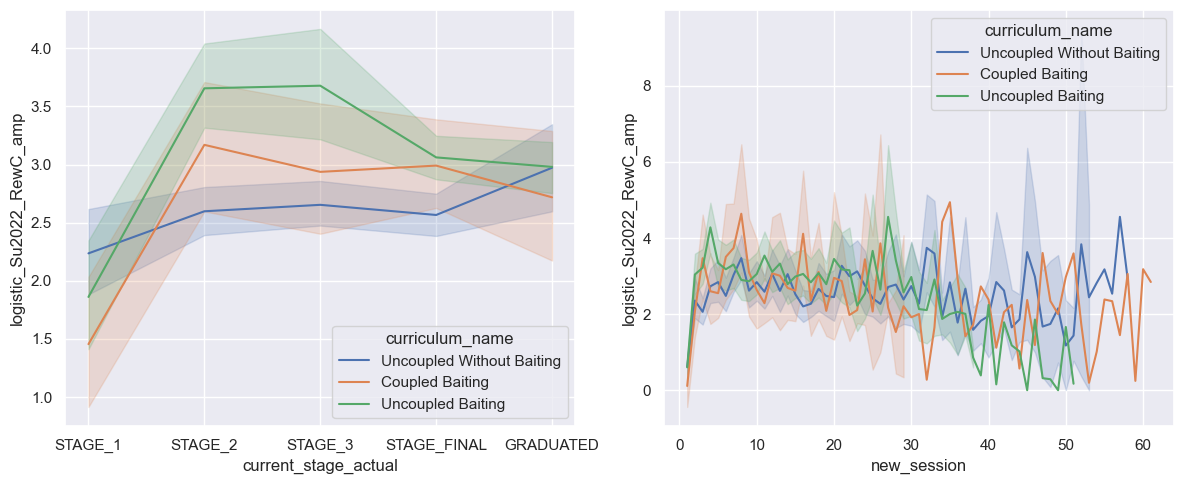

In [328]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='logistic_Su2022_RewC_amp', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='logistic_Su2022_RewC_amp', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

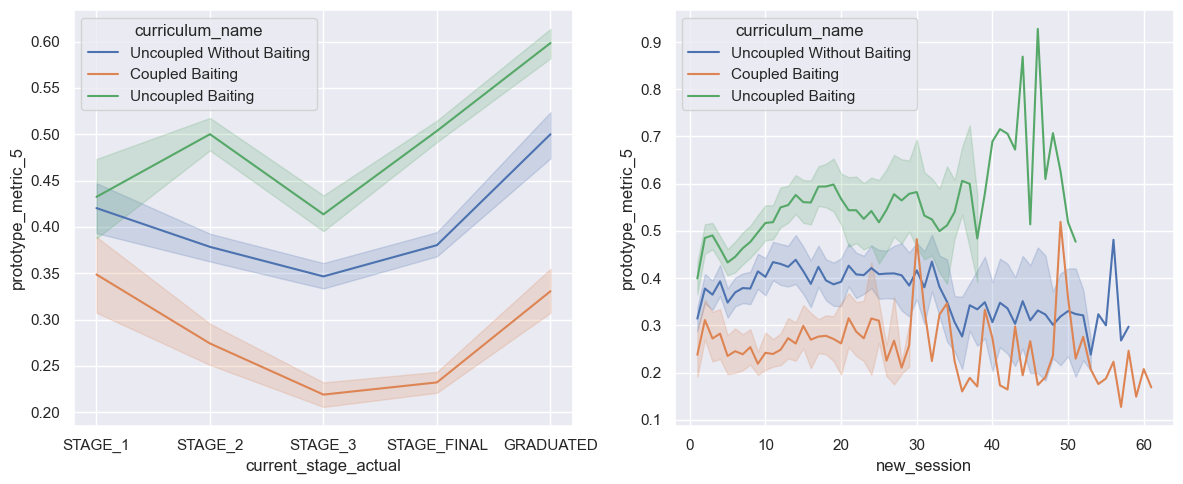

In [329]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='prototype_metric_5', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='prototype_metric_5', 
             hue='curriculum_name', ax=ax2)

plt.tight_layout()

In [416]:
# Array utils
array_df = test_session_df.copy()

# Create custom group limits
stage_counts = array_df.groupby(['subject_id', 'current_stage_actual']).size().unstack(fill_value=0)
stage_lims = {stage: int(stage_counts[stage].quantile(0.95)) for stage in stage_counts.columns}

array_df = bu.filter_by_group_size(array_df, 
                                   group_col='subject_id', 
                                   category_col='current_stage_actual', 
                                   category_limits=stage_lims)

# Metric to evaluate
metric = 'prototype_metric_5'

# Generate prototype metric arrays
metric_arrays = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric=metric, 
                          task_col=None)

# Generate foraging eff array for comparison
foraging_eff_array = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric='foraging_eff', 
                          task_col=None)

# Univariate arrays
uni_arrays = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric= 'finished_rate', 
                          task_col=None)

# Summary statistics
au.summary_statistics(metric_arrays)

No data found for nan
No data found for nan
No data found for nan


,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,STAGE_3,N/A,"(341, 6)",0.565982,1.198442,0,6,0
1,STAGE_FINAL,N/A,"(341, 15)",1.771261,3.467553,0,15,0
2,STAGE_2,N/A,"(341, 5)",0.703812,1.187774,0,5,0
3,STAGE_1,N/A,"(341, 3)",0.252199,0.593985,0,3,0
4,GRADUATED,N/A,"(341, 10)",0.633431,2.060079,0,10,0


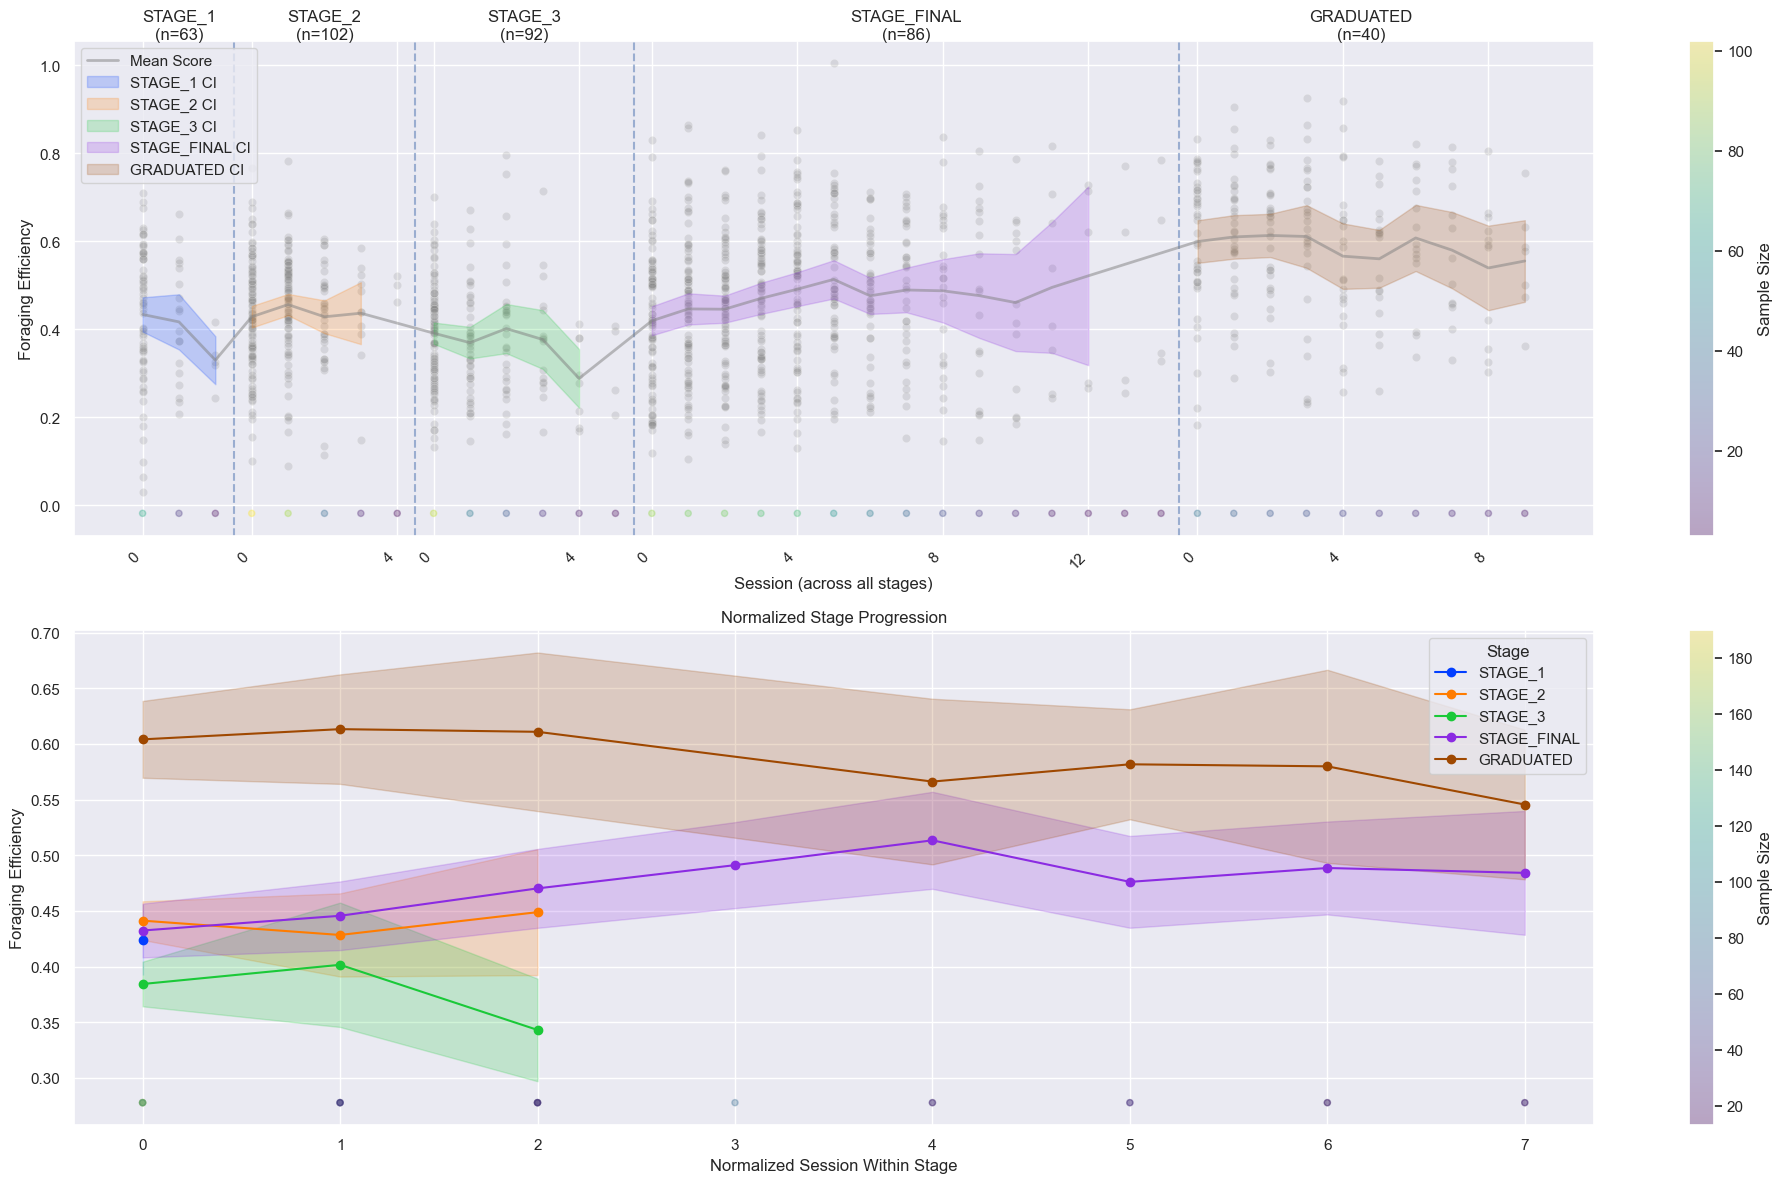


Detailed Statistics by Stage:
               N   Mean    Std    SEM    Min    Max  Subjects
Stage                                                        
GRADUATED    216  0.593  0.156  0.011  0.183  0.926        40
STAGE_1       86  0.424  0.151  0.016  0.030  0.710        63
STAGE_2      240  0.440  0.120  0.008  0.090  0.782       102
STAGE_3      193  0.381  0.127  0.009  0.131  0.797        92
STAGE_FINAL  604  0.466  0.163  0.007  0.104  1.005        86

Outlier Analysis:

STAGE_3:
Number of outliers: 1
Outlier values: [0.79730212]
Percentage: 0.5%

STAGE_FINAL:
Number of outliers: 1
Outlier values: [1.00496414]
Percentage: 0.2%

Performance Summary:

STAGE_1:
Sessions: 3
Mean ± SEM: 0.393 ± 0.032
Subjects: 63
Sample size range: 5-63
Sessions below threshold: 0

STAGE_2:
Sessions: 5
Mean ± SEM: 0.437 ± 0.006
Subjects: 102
Sample size range: 3-102
Sessions below threshold: 1

STAGE_3:
Sessions: 6
Mean ± SEM: 0.365 ± 0.018
Subjects: 92
Sample size range: 4-92
Sessions below thresh

In [435]:
au.ci_plot_metric(metric_arrays, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True)